In [1]:
import fiona
import shapely
import rasterio
import torch
import pyproj
from rasterio import features
from fiona.transform import transform as f_transform
import numpy as np
from shapely import plotting
from matplotlib import colors
from matplotlib.collections import PatchCollection
from copy import copy
from rasterio import plot as rioplt


/home/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
shapefile = fiona.open("/mnt/d/pfournie/Documents/data/alumhi/OCS_2019_210712_VERSION_FINALE_Merge.shp", 'r')

In [3]:
shapefile.meta

{'driver': 'ESRI Shapefile',
 'schema': {'properties': {'Area_ha': 'float:13.11', 'OCS_2019': 'str:254'},
  'geometry': 'Polygon'},
 'crs': CRS.from_epsg(2154),
 'crs_wkt': 'PROJCS["RGF93 v1 / Lambert-93",GEOGCS["RGF93 v1",DATUM["Reseau_Geodesique_Francais_1993_v1",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6171"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4171"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",46.5],PARAMETER["central_meridian",3],PARAMETER["standard_parallel_1",49],PARAMETER["standard_parallel_2",44],PARAMETER["false_easting",700000],PARAMETER["false_northing",6600000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2154"]]'}

In [4]:
feature = next(iter(shapefile))
poly2154 = shapely.Polygon(feature['geometry']['coordinates'][0][0])

In [5]:
raster = rasterio.open('/mnt/d/pfournie/Documents/data/alumhi/data_2019_20cm.tif', 'r')

In [6]:
minx, miny, maxx, maxy = shapely.geometry.shape(poly2154).bounds

In [7]:
minx, miny, maxx, maxy

(702995.3676260039, 6500759.778640761, 703107.5720454454, 6500802.943679454)

In [8]:
(minx, maxx), (miny, maxy) = f_transform(shapefile.crs, raster.crs, [minx, maxx], [miny, maxy])

In [9]:
minx, miny, maxx, maxy

(3.038428477160008, 45.60635315973692, 3.039868260953599, 45.6067413504363)

In [10]:
poly_window = rasterio.windows.from_bounds(minx, miny, maxx, maxy, transform=raster.transform)

In [11]:
poly_window = poly_window.round_offsets().round_lengths()

In [12]:
poly_window

Window(col_off=30299, row_off=68813, width=567, height=216)

In [13]:
img = raster.read(window=poly_window, out_dtype=np.uint8).transpose(1,2,0)[...,:3]

In [14]:
import matplotlib.pyplot as plt

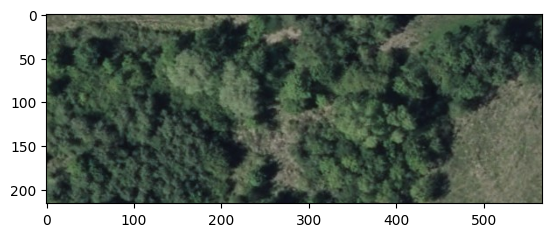

In [15]:
plt.imshow(img)

In [16]:
feature['properties']['OCS_2019']

'friche'

In [17]:
from itertools import product

def get_tiles(nols, nrows, size, size2=None, step=None, step2=None, col_offset=0, row_offset=0, cover_all=True):
    
    if step is None: step = size
    if size2 is None: size2 = size
    if step2 is None: step2 = step

    max_col_offset = int(np.ceil((nols-size)/step))
    # Remove all offsets such that offset+size > nols and add one offset to
    # reach nols
    col_offsets = list(range(col_offset, col_offset + nols, step))[:max_col_offset+int(cover_all)]
    if cover_all:
        col_offsets[max_col_offset] = col_offset + nols - size

    max_row_offset = int(np.ceil((nrows-size2)/step2))
    # Remove all offsets such that offset+size > nols and add one offset to
    # reach nols
    row_offsets = list(range(row_offset, row_offset + nrows, step2))[:max_row_offset+int(cover_all)]
    if cover_all:
        row_offsets[max_row_offset] = row_offset + nrows - size2

    offsets = product(col_offsets, row_offsets)
    for col_off, row_off in offsets:
        yield rasterio.windows.Window(col_off=col_off, row_off=row_off, width=size, height=size2)

In [18]:
tiles = get_tiles(
    nols=poly_window.width,
    nrows=poly_window.height,
    size=128,
    step=128,
    col_offset=poly_window.col_off,
    row_offset=poly_window.row_off
)

In [19]:
def generate_polygon(bbox):
    """
    Generates a list of coordinates: [[x1,y1],[x2,y2],[x3,y3],[x4,y4],[x1,y1]]
    """
    return [[bbox[0],bbox[1]],
             [bbox[2],bbox[1]],
             [bbox[2],bbox[3]],
             [bbox[0],bbox[3]],
             [bbox[0],bbox[1]]]

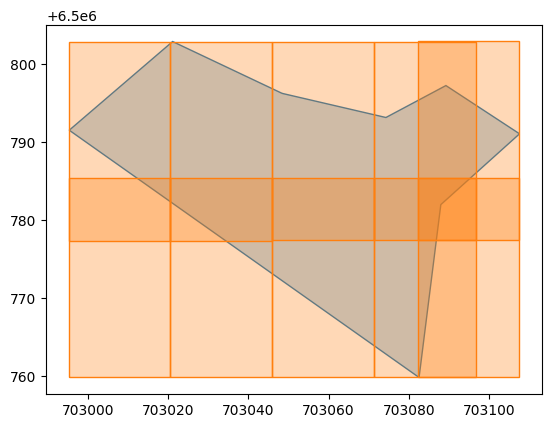

In [20]:
color = colors.to_rgba("C0")
facecolor = list(color)
facecolor[-1] = 0.3
facecolor = tuple(facecolor)
edgecolor = color
fig, ax = plt.subplots()

poly_patch = plotting.patch_from_polygon(poly2154, facecolor=facecolor, edgecolor=edgecolor)
ax.add_patch(poly_patch)

for tile in tiles:
    left, bottom, right, top = rasterio.windows.bounds(tile, transform=raster.transform)
    (minx, maxx), (miny, maxy) = f_transform(raster.crs, shapefile.crs, [left, right], [bottom, top])
    tile_poly = shapely.Polygon(generate_polygon((minx, miny, maxx, maxy)))
    color = colors.to_rgba("C1")
    facecolor = list(color)
    facecolor[-1] = 0.3
    facecolor = tuple(facecolor)
    edgecolor = color
    tile_patch = plotting.patch_from_polygon(tile_poly, facecolor=facecolor, edgecolor=edgecolor)
    ax.add_patch(tile_patch)

ax.autoscale_view()

In [21]:
shapely.area(shapely.intersection(tile_poly, poly2154)) / shapely.area(tile_poly)

0.1550110526331433

In [22]:
from shapely import ops

In [42]:
big_poly = shapely.union_all([shapely.geometry.shape(feature['geometry']) for feature in shapefile])
projection = pyproj.Transformer.from_crs(shapefile.crs, raster.crs, always_xy=True)
big_poly_proj = ops.transform(projection.transform, big_poly)

In [43]:
big_poly_proj.type

/tmp/ipykernel_1637/4152275628.py:1: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  big_poly_proj.type


'Polygon'

Polygon


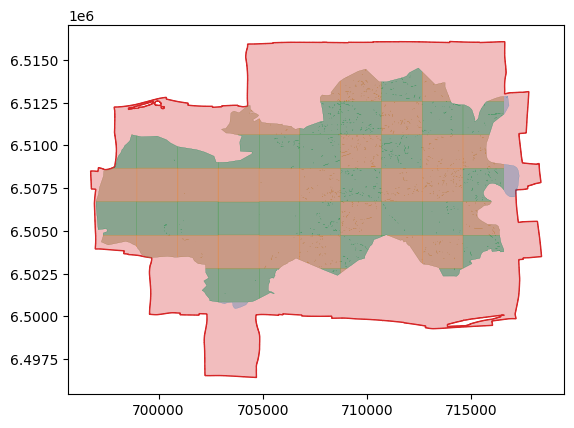

In [46]:
raster = rasterio.open('/mnt/d/pfournie/Documents/data/alumhi/1946-3.tif', 'r')
mask = raster.dataset_mask()


minx, miny, maxx, maxy = big_poly_proj.bounds
big_poly_window = rasterio.windows.from_bounds(minx, miny, maxx, maxy, transform=raster.transform)
big_poly_window = big_poly_window.round_offsets().round_lengths()

big_poly_tiles = get_tiles(
    nols=big_poly_window.width,
    nrows=big_poly_window.height,
    size=2000,
    step=2000,
    col_offset=big_poly_window.col_off,
    row_offset=big_poly_window.row_off,
    cover_all=False
)

fig2, ax2 = plt.subplots()

color = colors.to_rgba(f"C3")
facecolor = list(color)
facecolor[-1] = 0.3
facecolor = tuple(facecolor)
edgecolor = color
for shape, value in rasterio.features.shapes(mask, mask=mask, connectivity=8, transform=raster.transform):
    poly = shapely.geometry.shape(shape)
    print(poly.geom_type)
    patch = plotting.patch_from_polygon(poly, facecolor=facecolor, edgecolor=edgecolor)
    ax2.add_patch(patch)

color = colors.to_rgba("C0")
facecolor = list(color)
facecolor[-1] = 0.3
facecolor = tuple(facecolor)
edgecolor = color
big_poly_patch = plotting.patch_from_polygon(
    big_poly_proj, 
    facecolor=facecolor, 
    edgecolor=edgecolor,
    linewidth=0.1
)
ax2.add_patch(big_poly_patch)

intersections = []
for tile in big_poly_tiles:
    left, bottom, right, top = rasterio.windows.bounds(tile, transform=raster.transform)
    tile_poly = shapely.Polygon(generate_polygon((left, bottom, right, top)))
    inter = shapely.intersection(tile_poly, big_poly_proj)
    for part in shapely.get_parts(inter):
        if shapely.get_type_id(part)==3 and not part.is_empty:
            intersections.append(part)

for i, inter_poly in enumerate(intersections):
    color = colors.to_rgba(f"C{i%2+1}")
    facecolor = list(color)
    facecolor[-1] = 0.3
    facecolor = tuple(facecolor)
    edgecolor = color
    tile_patch = plotting.patch_from_polygon(
        inter_poly,
        facecolor=facecolor,
        edgecolor=edgecolor,
        linewidth=0.1
    )
    ax2.add_patch(tile_patch)

ax2.autoscale_view()

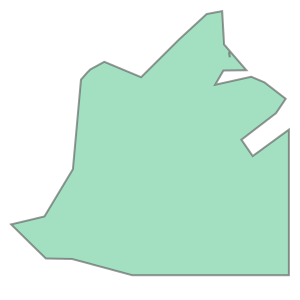

In [68]:
intersections[14]

In [45]:
#minx, miny, maxx, maxy = big_poly.bounds
#(minx, maxx), (miny, maxy) = f_transform(shapefile.crs, raster.crs, [minx, maxx], [miny, maxy])
#big_poly_window = rasterio.windows.from_bounds(minx, miny, maxx, maxy, transform=raster.transform)
#big_poly_window = big_poly_window.round_offsets().round_lengths()
#big_poly_tiles = get_tiles(
#    nols=big_poly_window.width,
#    nrows=big_poly_window.height,
#    size=10000,
#    step=10000,
#    col_offset=big_poly_window.col_off,
#    row_offset=big_poly_window.row_off,
#    cover_all=False
#)
#
#color = colors.to_rgba("C0")
#facecolor = list(color)
#facecolor[-1] = 0.3
#facecolor = tuple(facecolor)
#edgecolor = color
#fig2, ax2 = plt.subplots()
#
#big_poly_patch = plotting.patch_from_polygon(big_poly, facecolor=facecolor, edgecolor=edgecolor)
#ax2.add_patch(big_poly_patch)
#
#intersections = []
#for tile in big_poly_tiles:
#    left, bottom, right, top = rasterio.windows.bounds(tile, transform=raster.transform)
#    (minx, maxx), (miny, maxy) = f_transform(raster.crs, shapefile.crs, [left, right], [bottom, top])
#    tile_poly = shapely.Polygon(generate_polygon((minx, miny, maxx, maxy)))
#    inter = shapely.intersection(tile_poly, big_poly)
#    if not inter.is_empty:
#        intersections.append(inter)
#
#for i, inter_poly in enumerate(intersections):
#    color = colors.to_rgba(f"C{i%2+1}")
#    facecolor = list(color)
#    facecolor[-1] = 0.3
#    facecolor = tuple(facecolor)
#    edgecolor = color
#    tile_patch = plotting.patch_from_polygon(inter_poly, facecolor=facecolor, edgecolor=edgecolor)
#    ax2.add_patch(tile_patch)
#
#ax2.autoscale_view()

In [26]:
import rasterio.mask

0.912693493932728


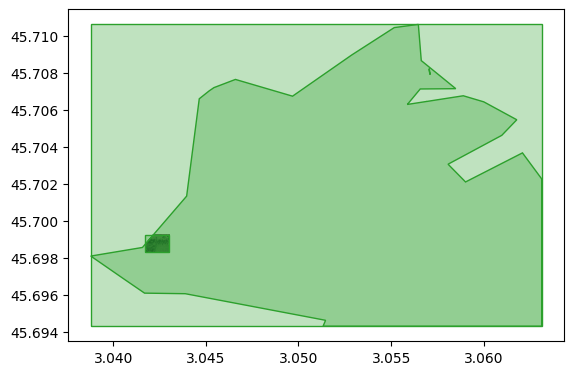

In [39]:
train_zone = intersections[16] # raster coords
train_zone_bounds = train_zone.bounds
# raster pixel coords
tile = rasterio.windows.from_bounds(
    *train_zone_bounds, 
    transform=raster.transform
).round_offsets().round_lengths()
tile_poly = shapely.Polygon(generate_polygon(train_zone_bounds))
tile_patch = plotting.patch_from_polygon(tile_poly, facecolor=facecolor, edgecolor=edgecolor)

area = 0
crop_size=512
while area <= 0 or area >= 1:
    cx = tile.col_off + np.random.randint(0, tile.width - crop_size + 1)
    cy = tile.row_off + np.random.randint(0, tile.height - crop_size + 1)
    # raster pixel coords
    crop = rasterio.windows.Window(cx, cy, crop_size, crop_size)
    left, bottom, right, top = rasterio.windows.bounds(crop, transform=raster.transform)
    crop_poly = shapely.Polygon(generate_polygon((left, bottom, right, top)))
    crop_patch = plotting.patch_from_polygon(crop_poly, facecolor=facecolor, edgecolor=edgecolor)
    intersection = shapely.intersection(crop_poly, train_zone)
    area = shapely.area(intersection) / shapely.area(crop_poly)
print(area)
train_zone_patch = plotting.patch_from_polygon(train_zone, facecolor=facecolor, edgecolor=edgecolor)
crop_img, crop_transform = rasterio.mask.mask(raster, shapes=[intersection], crop=True)


fig3, ax3 = plt.subplots()
ax3.add_patch(tile_patch)
ax3.add_patch(crop_patch)
ax3.add_patch(train_zone_patch)
rioplt.show(crop_img, ax=ax3, transform=crop_transform)
ax3.autoscale_view()

AttributeError: 'Polygon' object has no attribute '__att__'

In [60]:
raster1946 = rasterio.open('/mnt/d/pfournie/Documents/data/alumhi/1946-3.tif', 'r')
mask = raster1946.dataset_mask()
mask_polys = []
for shape, value in rasterio.features.shapes(
    mask, mask=mask, connectivity=8, transform=raster1946.transform
):
    mask_polys.append(shapely.geometry.shape(shape))
raster_mask_poly = shapely.geometry.MultiPolygon(mask_polys)

In [82]:
class PolyRaster(torch.utils.data.Dataset):
    
    def __init__(
        self,
        raster_img,
        #raster_label,
        polygon,
        crop_size,
        raster_mask_poly=None
    ):
        self.raster_img = raster_img
        #self.raster_label = raster_label
        self.polygon = polygon
        self.crop_size = crop_size
        
        #assert crs?
        self.tile = rasterio.windows.from_bounds(
            *polygon.bounds, 
            transform=raster_img.transform
        ).round_offsets().round_lengths()
        print(self.tile)
        
        if raster_mask_poly:
            self.raster_mask_poly = raster_mask_poly
        else:
            mask = raster_img.dataset_mask()
            mask_polys = []
            for shape, value in rasterio.features.shapes(
                mask, mask=mask, connectivity=8, transform=raster_img.transform
            ):
                mask_polys.append(shapely.geometry.shape(shape))
            self.raster_mask_poly = shapely.geometry.MultiPolygon(mask_polys)
        
    def __getitem__(self, idx):
        
        area = 0
        full = False
        while area <= 0.8 or not full:
            cx = self.tile.col_off + np.random.randint(0, self.tile.width - self.crop_size + 1)
            cy = self.tile.row_off + np.random.randint(0, self.tile.height - self.crop_size + 1)
            # raster pixel coords
            crop = rasterio.windows.Window(cx, cy, crop_size, crop_size)
            left, bottom, right, top = rasterio.windows.bounds(
                crop,
                transform=self.raster_img.transform
            )
            crop_poly = shapely.Polygon(generate_polygon((left, bottom, right, top)))
            
            # checking that the crop intersects the train_zone enough
            intersection = shapely.intersection(crop_poly, self.polygon)
            area = shapely.area(intersection) / shapely.area(crop_poly)
            
            # checking that the crop does not contain pixels out of the initial raster mask
            intersection_mask = shapely.intersection(crop_poly, self.raster_mask_poly)
            full = shapely.area(intersection_mask) / shapely.area(crop_poly) == 1
        
        crop_img = self.raster_img.read(window=crop, out_dtype=np.uint8)
        transform = rasterio.windows.transform(crop, transform=self.raster_img.transform)
        
        return crop_img, transform

In [83]:
ds = PolyRaster(
    raster_img=raster1946,
    polygon=intersections[14],
    crop_size=512,
    raster_mask_poly=raster_mask_poly
)

Window(col_off=6418, row_off=3829, width=1849, height=1758)


(2, 512, 512)


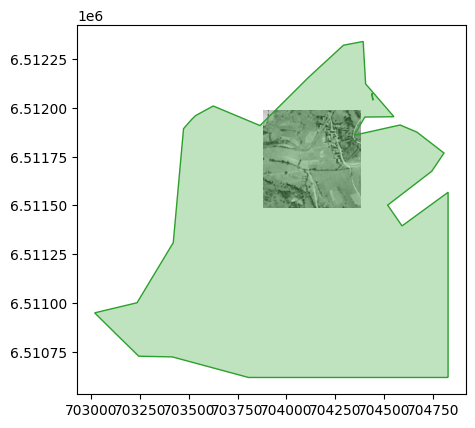

In [86]:
crop_img, transform = ds[0]
fig3, ax3 = plt.subplots()
polygon_patch = plotting.patch_from_polygon(intersections[14], facecolor=facecolor, edgecolor=edgecolor)
ax3.add_patch(polygon_patch)
rioplt.show(crop_img[0,...], ax=ax3, transform=transform, cmap='gray')
ax3.autoscale_view()

In [28]:
def mask_to_polygons_layer(mask):
    all_polygons = []
    for shape, value in features.shapes(mask.astype(np.int16), mask=(mask >0), transform=rasterio.Affine(1.0, 0, 0, 0, 1.0, 0)):
        return shapely.geometry.shape(shape)
        all_polygons.append(shapely.geometry.shape(shape))

    all_polygons = shapely.geometry.MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = shapely.geometry.MultiPolygon([all_polygons])
    return all_polygons

polygons = mask_to_polygons_layer(threshold)

NameError: name 'threshold' is not defined

In [ ]:
raster1946 = rasterio.open('/mnt/d/pfournie/Documents/data/alumhi/1946-3.tif', 'r')
raster1954 = rasterio.open('/mnt/d/pfournie/Documents/data/alumhi/1954-3.tif', 'r')
raster1962 = rasterio.open('/mnt/d/pfournie/Documents/data/alumhi/1962-3.tif', 'r')

In [ ]:
mask46 = raster1946.dataset_mask()

In [ ]:
mask46.shape

In [ ]:
#fig4, ax4 = plt.subplots()
#
#for i, raster in enumerate([raster1946, raster1954, raster1962]):
#    
#    color = colors.to_rgba(f"C{i}")
#    facecolor = list(color)
#    facecolor[-1] = 0.3
#    facecolor = tuple(facecolor)
#    edgecolor = color
#    
#    mask = raster.dataset_mask()
#    for shape, value in rasterio.features.shapes(mask, mask=mask, connectivity=8, transform=raster.transform):
#        poly = shapely.geometry.shape(shape)
#        print(i, poly.geom_type)
#        patch = plotting.patch_from_polygon(poly, facecolor=facecolor, edgecolor=edgecolor)
#        ax4.add_patch(patch)
#
#ax4.autoscale_view()

In [ ]:
ax4.add_patch(copy(big_poly_patch))

In [ ]:
len(list(raster46shapes))